# CHWP hk data tutorial

We use G3tHWP (https://sotodlib.readthedocs.io/en/latest/hwp.html#g3thwp) to load hwp hk data.\
The hwp hk data incrude encoder data before the angle analysis.

In [2]:
import sys
import os
sys.path.insert(0, '/so/home/jsugiyama/git/sotodlib/') # please comment out this line
import numpy as np
from statistics import mean, median,variance,stdev
import datetime as dt
import time as tm
import scipy.interpolate
from scipy import signal
import matplotlib.pyplot as plt
from iminuit import Minuit
import so3g
from sotodlib import core, flags, tod_ops, sim_flags
from sotodlib.hwp.g3thwp import G3tHWP

The config file for G3tHWP should include "data_dir" and "field_instance" suitable for the hk data you read. Other parameters are common for all SATs.

In [21]:
hwp = G3tHWP(config_file="satp1_hwp_context.yaml")

## Load data

You can load the hwp hk data with:\
hwp.load_data(start=None, end=None, data_dir=None, instance=None)

In [22]:
start = 1704338000
end =   1704338100
hk_hwp = hwp.load_data(start, end)

In [23]:
hk_hwp.keys()

dict_keys(['rising_edge_count', 'irig_time', 'counter', 'counter_index', 'irig_synch_pulse_clock_time', 'irig_synch_pulse_clock_counts', 'quad', 'rising_edge_count_2', 'irig_time_2', 'counter_2', 'counter_index_2', 'irig_synch_pulse_clock_time_2', 'irig_synch_pulse_clock_counts_2', 'quad_2'])

The suffix '_2' is for the second encoder data.

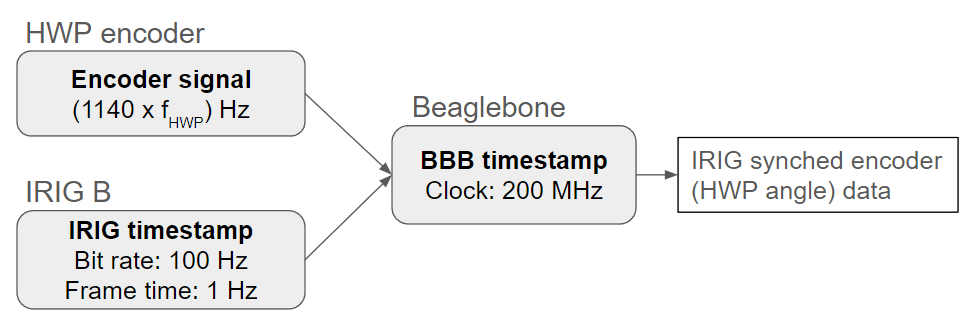

The HWP encoder signal is synched with IRIG signal through Beaglebone black (BBB) 200 MHz clock signal. Here we plot the encoder data of each key.

## rising_edge_count

Text(0.5, 1.0, 'rising edge count')

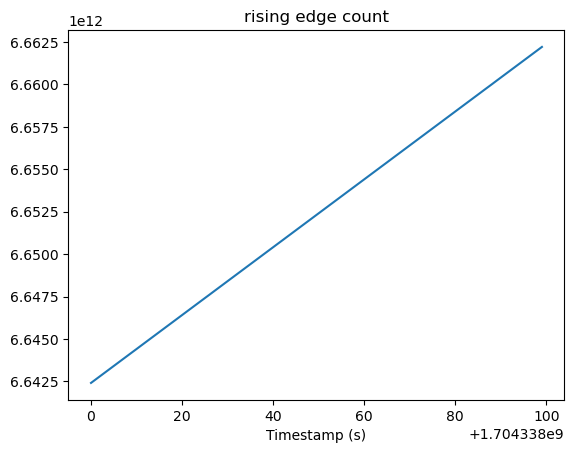

In [24]:
plt.figure()
plt.plot(*hk_hwp['rising_edge_count'])
plt.xlabel("Timestamp (s)")
plt.title("rising edge count")

The 'rising_edge_count' incrementally counts how many times 200 MHz signals rose up in one second of IRIG clock.\
The x axis is the Beaglebone timestamp.

## irig_time

The 'irig_time' accounts for the IRIG timestamp per one second.\
The x axis is the Beaglebone timestamp.

## counter

Text(0.5, 1.0, 'counter')

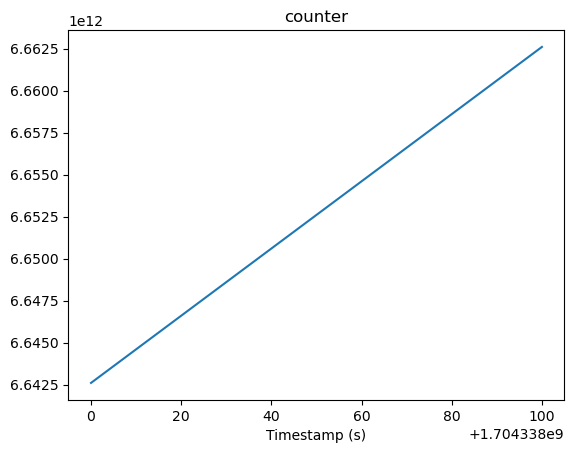

In [25]:
plt.figure()
plt.plot(*hk_hwp['counter'])
plt.xlabel("Timestamp (s)")
plt.title("counter")

The 'counter' incrementally counts how many times 200 MHz signals rose up between the encoder signal edges.\
The x axis is the Beaglebone timestamp.\
We have 570-1 slots (one reference slot is skipped to calculate the rotational angle) on the encoder disk.\
So we will count (570-1)*2=1138 encoder edge signals per one rotation.\

(0.0, 0.002)

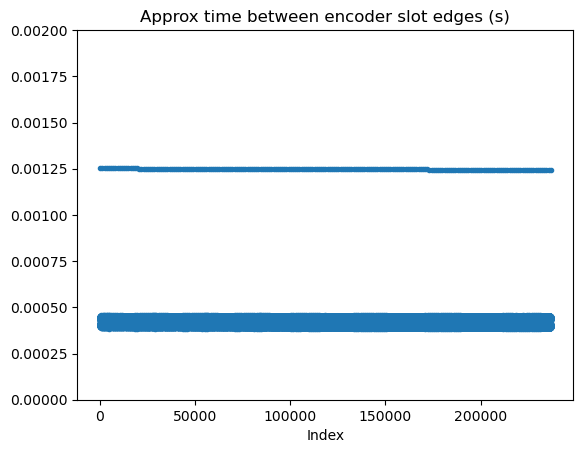

In [26]:
plt.figure()
plt.plot(np.diff(hk_hwp['counter'][1])/200E6, '.')
plt.xlabel("Index")
plt.title("Approx time between encoder slot edges (s)")
plt.ylim(0, 0.002)

Taking diff of the 'counter' signal is a good way to check the encoder signal jitter by our eyes.\
The reference point which have large duration appears every 1138 index if there is no false signal.\
If you find spurious signals here, the encoder system should take a maintainance (e.g. potentiometer tuning, investigations of emitter LEDs, cables or groundings).

In [27]:
# just a toy model. you don't need it for analysis.
def reproduce_encoder_signal(timestamp, dt=0.00001):
    t_encoder = []
    s_encoder = []
    for i in range(len(timestamp)):
        t = timestamp[i]
        if i%2 == 0:
            t_encoder.append(t)
            t_encoder.append(t+dt)
            s_encoder.append(0)
            s_encoder.append(1)
        elif i%2 == 1:
            t_encoder.append(t)
            t_encoder.append(t+dt)
            s_encoder.append(1)
            s_encoder.append(0)
    return t_encoder, s_encoder
        

Text(0, 0.5, 'Encoder signal')

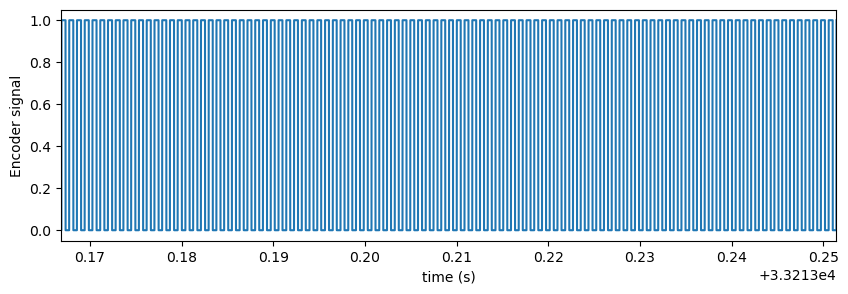

In [28]:
timestamp = hk_hwp['counter'][1]/200E6
plt.figure(figsize=(10,3))
plt.plot(*reproduce_encoder_signal(timestamp))
plt.xlim(timestamp[400], timestamp[600])
plt.xlabel("time (s)")
plt.ylabel("Encoder signal")

## counter_index

The 'counter' incrementally counts the index of the encoder signal edges.\
The x axis is the Beaglebone timestamps.

## irig_synch_pulse_clock_time, irig_synch_pulse_clock_counts

The 'irig_synch_pulse_clock_counts' incrementally counts how many times 200 MHz signals rose up in 0.1 second of IRIG clock.\
The 'irig_synch_pulse_clock_time' accounts for the IRIG timestamp per 0.1 second.\
The x axis is the Beaglebone timestamp.

## quad

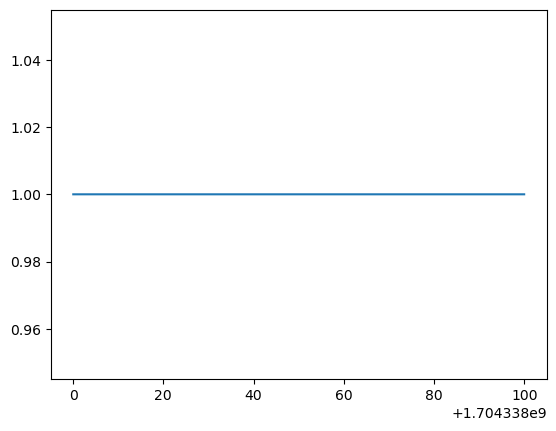

In [29]:
plt.figure()
plt.plot(*hk_hwp['quad'])

The 'quad' returns the rotation direction of the hwp in 0 or 1.\
Note: The 'quad' flip is sometimes seen in the current chwp data at site.

# Calculate angle

HWP angle TOD is calculated with:\
hwp.analyze(hk_hwp)

In [30]:
solved = hwp.analyze(hk_hwp, mod2pi=False)

In [31]:
solved.keys()

dict_keys(['locked', 'stable', 'hwp_rate', 'slow_time', 'fast_time', 'angle', 'ref_indexes', 'locked_2', 'stable_2', 'hwp_rate_2', 'slow_time_2', 'fast_time_2', 'angle_2', 'ref_indexes_2'])

'angle' accounts for the discrete HWP rotational angle (rad).\
'fast_time' accounts for the timing of each angle data point synchronized to IRIG timestamps.

Text(0, 0.5, 'Angle (rad)')

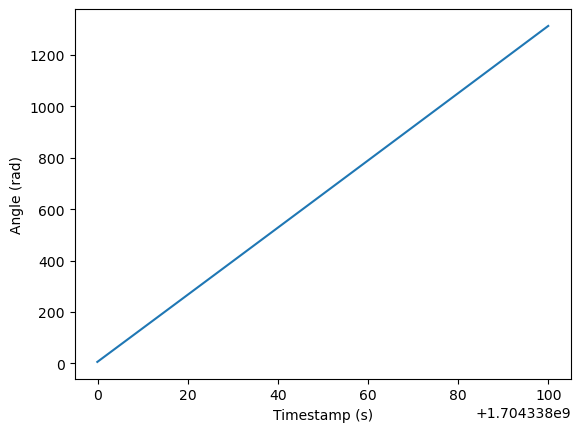

In [32]:
plt.figure()
plt.plot(solved['fast_time'], solved['angle'])
plt.xlabel('Timestamp (s)')
plt.ylabel('Angle (rad)')

'hwp.eval_angle' is a function that evaluates the encoder pattern and reduces the angle jitter.\
This function replaces 'fast_time' with the pattern-subtracted solution.\
'fast_time' before the subtraction remains as 'fast_time_raw'.\
Off-center of the hwp is calculated and its effect is subtracted by 'hwp.eval_offcentering' and 'hwp.correct_offcentering'.

In [33]:
hwp.eval_angle(solved)
hwp.eval_angle(solved, suffix='_2')
hwp.eval_offcentering(solved)
hwp.correct_offcentering(solved)

In [34]:
solved.keys()

dict_keys(['locked', 'stable', 'hwp_rate', 'slow_time', 'fast_time', 'angle', 'ref_indexes', 'locked_2', 'stable_2', 'hwp_rate_2', 'slow_time_2', 'fast_time_2', 'angle_2', 'ref_indexes_2', 'fast_time_moving_ave', 'angle_moving_ave', 'fast_time_raw', 'fast_time_moving_ave_2', 'angle_moving_ave_2', 'fast_time_raw_2', 'offcenter_idx1', 'offcenter_idx2', 'offcentering', 'offset_time', 'fast_time_ver2', 'fast_time_ver2_2', 'angle_old', 'angle_old_2'])

ver1 is for the raw angle, and ver2 is for  the template subtracted angle.

## Angle jitter analysis

The angle jitter around the rotation frequency (2 Hz) needs to be suppressed because the noise can be counted as the HWP synchronous signal when the timing jitter occurs.\
The PSD of angle jitter is good for the evaluation.

In [35]:
def angle_jitter_eval(solved, version=3, deg=1, suffix=''):
    def linear(t, angle, deg=1):
        p = np.polyfit(t-np.average(t), angle, deg=deg)
        pv = np.polyval(p, t-np.average(t))
        return pv

    if version==3:
        time_linear = np.linspace(solved['fast_time'+suffix][0], solved['fast_time'+suffix][-1], len(solved['fast_time'+suffix]))
        angle = scipy.interpolate.interp1d(solved['fast_time'+suffix], solved['angle'+suffix], kind='linear', fill_value='extrapolate')(time_linear)
        
    elif version==2:
        time_linear =np.linspace(solved['fast_time_ver2'+suffix][0], solved['fast_time_ver2'+suffix][-1], len(solved['fast_time_ver2'+suffix]))
        angle = scipy.interpolate.interp1d(solved['fast_time_ver2'+suffix], solved['angle_old'+suffix], kind='linear', fill_value='extrapolate')(time_linear)

    elif version==1:
        time_linear =np.linspace(solved['fast_time_raw'+suffix][0], solved['fast_time_raw'+suffix][-1], len(solved['fast_time_raw'+suffix]))
        angle = scipy.interpolate.interp1d(solved['fast_time_raw'+suffix], solved['angle_old'+suffix], kind='linear', fill_value='extrapolate')(time_linear)
    freq = np.median(solved['hwp_rate'])
    angle_linear = linear(time_linear, angle, deg)
    residual = angle - angle_linear
    f, p = signal.periodogram(residual, fs=freq*1140, window='hamming')
    return f, p

(1e-17, 50)

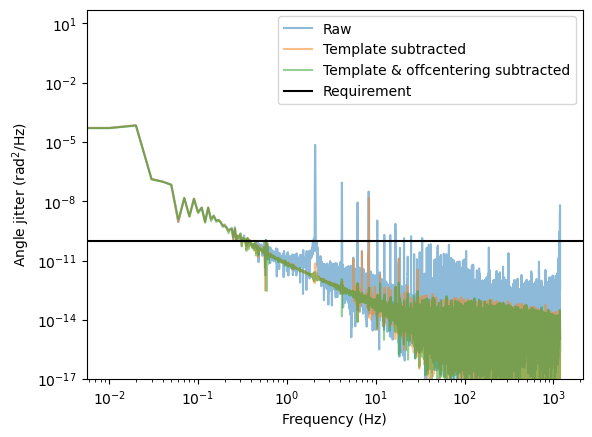

In [36]:
plt.figure()
f, p = angle_jitter_eval(solved, version=1, deg=3)
plt.loglog(f, p, alpha=0.5, label="Raw")
f, p = angle_jitter_eval(solved, version=2,  deg=3)
plt.loglog(f, p, alpha=0.5, label="Template subtracted")
f, p = angle_jitter_eval(solved, version=3,  deg=3)
plt.loglog(f, p, alpha=0.5, label="Template & offcentering subtracted")
plt.axhline(1E-10, color="black", label="Requirement")
plt.ylabel("Angle jitter (rad$^2/$Hz)")
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.ylim(1E-17, 50)

Before the pattern subtraction (blue), there is large noise around 2*N Hz.\
After the pattern subtraction, the angle jitter around 2 Hz is suppressed under the requirement (10 rad^2/Hz).\
Off-center subtraction doesn't contribute to the jitter suppression so much, but it corrects the angle offset of ~0.1 deg.